# Activity NN
## Tyler Barna

### Contents
1. [Import Modules and Data](#import)
2. [Visualizing Data](#data)  
3. [Analysis](#analysis)  
    3.1 [Poisson](#analysis1)  
    3.2 [Zero Inflated Poisson](#analysis2)

### 1. Import Modules and Data
<a id='import'></a>

In [65]:
import csv
import dis
import inspect
import os
import sys
import time

import arviz as az
import astropy
import astroquery
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import pymc as pm
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from pymc import Model, Normal, Gamma, find_MAP

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn.linear_model import LinearRegression as linreg
from sklearn import preprocessing as preproc

%matplotlib inline
plt.style.use("seaborn-colorblind")
mpl.rcParams.update({"axes.grid" : False})
plt.style.context(("seaborn-colorblind",))
pp = pprint.PrettyPrinter(indent=4)

## set seed for reproducibility
random.seed(5731)

## import data
dfc = pd.read_csv('clusters_xrays.csv')
display(dfc.describe())
dfgc = ascii.read('GC_allcolumns.txt').to_pandas()#.replace(-9999, np.nan)
display(dfgc.describe());

,LX,Ngal
count,1030.000000,1030.000000
mean,0.050871,13.330097
std,0.089347,16.666854
min,0.000008,3.000000
25%,0.010061,5.000000
50%,0.025341,8.000000
75%,0.049777,14.750000
max,1.014745,154.000000


,RA,DEC,D,e1,A_V,MV_T,e2,M_K,e3,N_GC,...,e5,R_e,e6,M_d,e6_1,M_G,e8,M_B,el,eu
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,...,297.000000,297.000000,297.000000,297.000000,297.00000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,-23.979294,-33.365019,6.907239,-30.678350,0.135367,-20.311178,0.247407,6543.111411,505.170394,2057.814478,...,-2047.718182,-1072.900067,-1110.570505,-2550.573044,-2558.63163,7.812054,0.110606,-7876.753838,-7877.476936,-7877.975253
std,580.790966,581.191404,584.606585,580.385908,0.196881,2.126069,0.116528,81948.005957,8306.564171,4510.222699,...,4049.288834,3107.041290,3147.838511,4375.297599,4370.56382,1.113858,0.060663,4096.998665,4095.602673,4094.640323
min,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,-24.190000,0.200000,-9999.000000,-9999.000000,0.000000,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.00000,5.140000,0.000000,-9999.000000,-9999.000000,-9999.000000
25%,3.669255,-33.233927,15.820000,0.560000,0.044000,-21.850000,0.200000,-25.065000,0.102000,50.000000,...,2.400000,1.220000,0.050000,-9999.000000,-9999.00000,7.040000,0.070000,-9999.000000,-9999.000000,-9999.000000
50%,11.699267,8.154306,20.150000,1.500000,0.084000,-20.800000,0.200000,-23.713000,0.104000,220.000000,...,4.600000,2.460000,0.160000,10.571000,0.03200,7.780000,0.110000,-9999.000000,-9999.000000,-9999.000000
75%,12.882202,27.060767,36.200000,4.090000,0.157000,-19.060000,0.250000,-21.708000,0.110000,1497.000000,...,8.600000,4.800000,0.410000,11.284000,0.04600,8.660000,0.130000,-9999.000000,-9999.000000,-9999.000000
max,23.641519,75.370944,284.200000,19.900000,2.583000,-13.000000,1.440000,999999.000000,99999.000000,32500.000000,...,46.500000,55.000000,20.000000,12.726000,0.21000,10.120000,0.570000,10.320000,9.950000,0.620000


### 2. Visualizing Data
<a id='data'></a>

As per the assignment, we should consider the relation between the absolute luminosity (MV_T) and the dynamical mass (M_d) in $\texttt{GC\_allcolumns.txt}$.

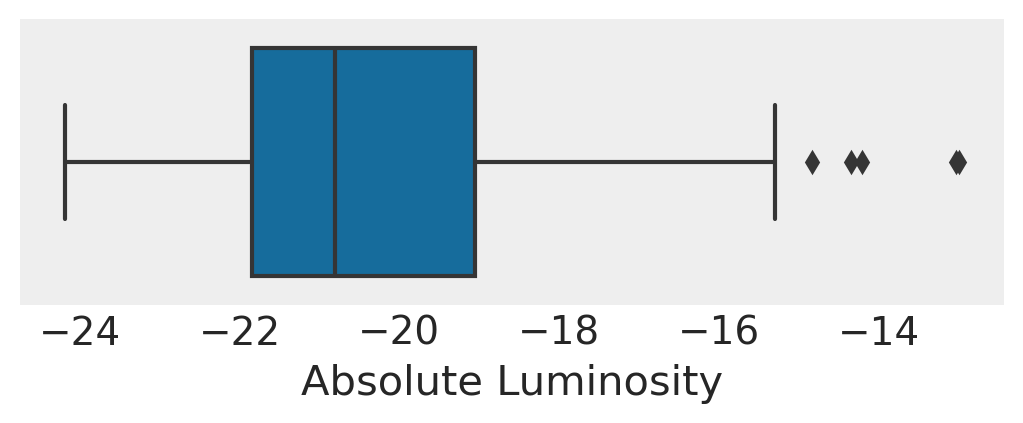

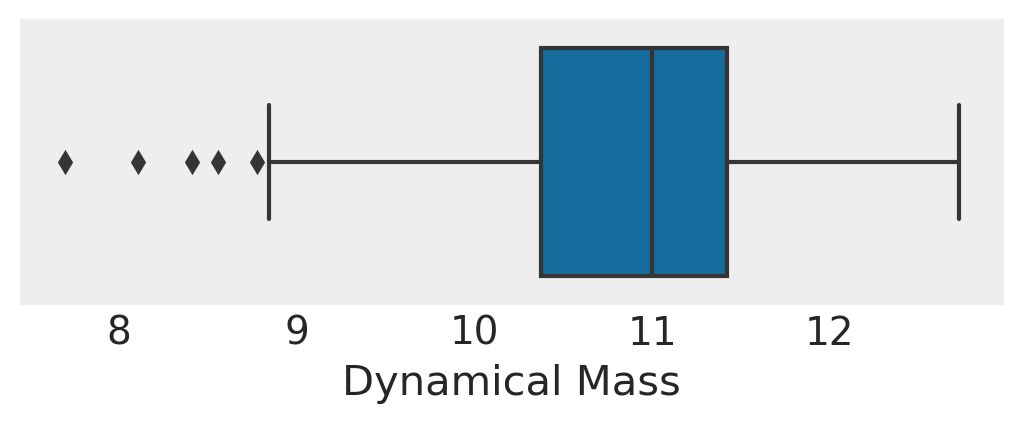

<Figure size 800x800 with 0 Axes>

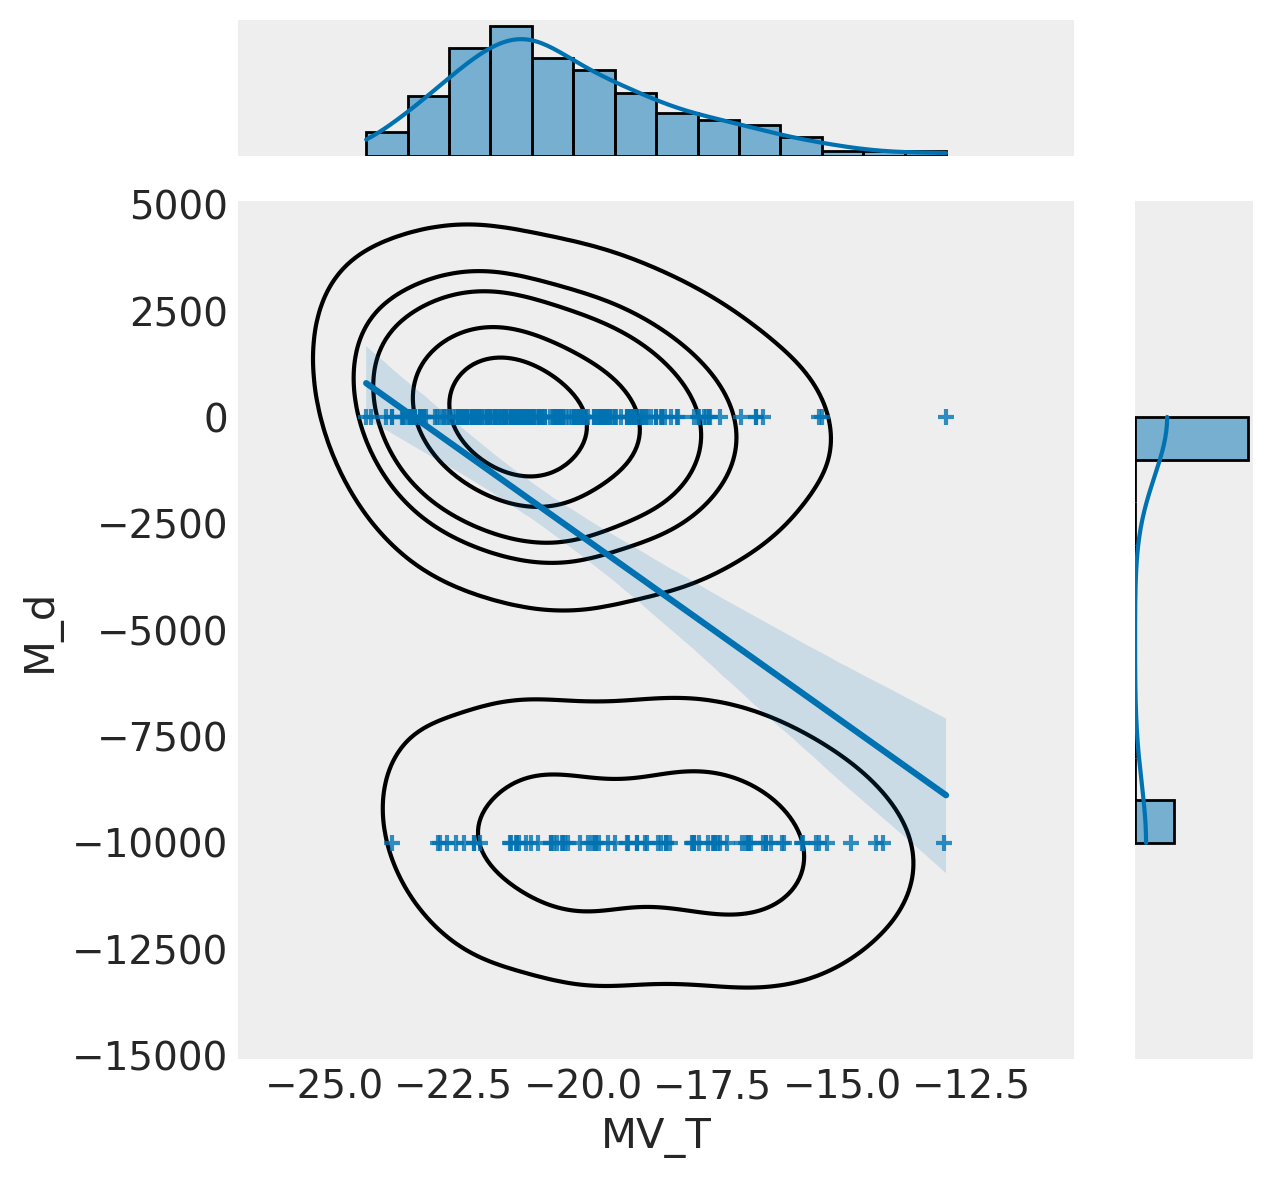

<Figure size 800x800 with 0 Axes>

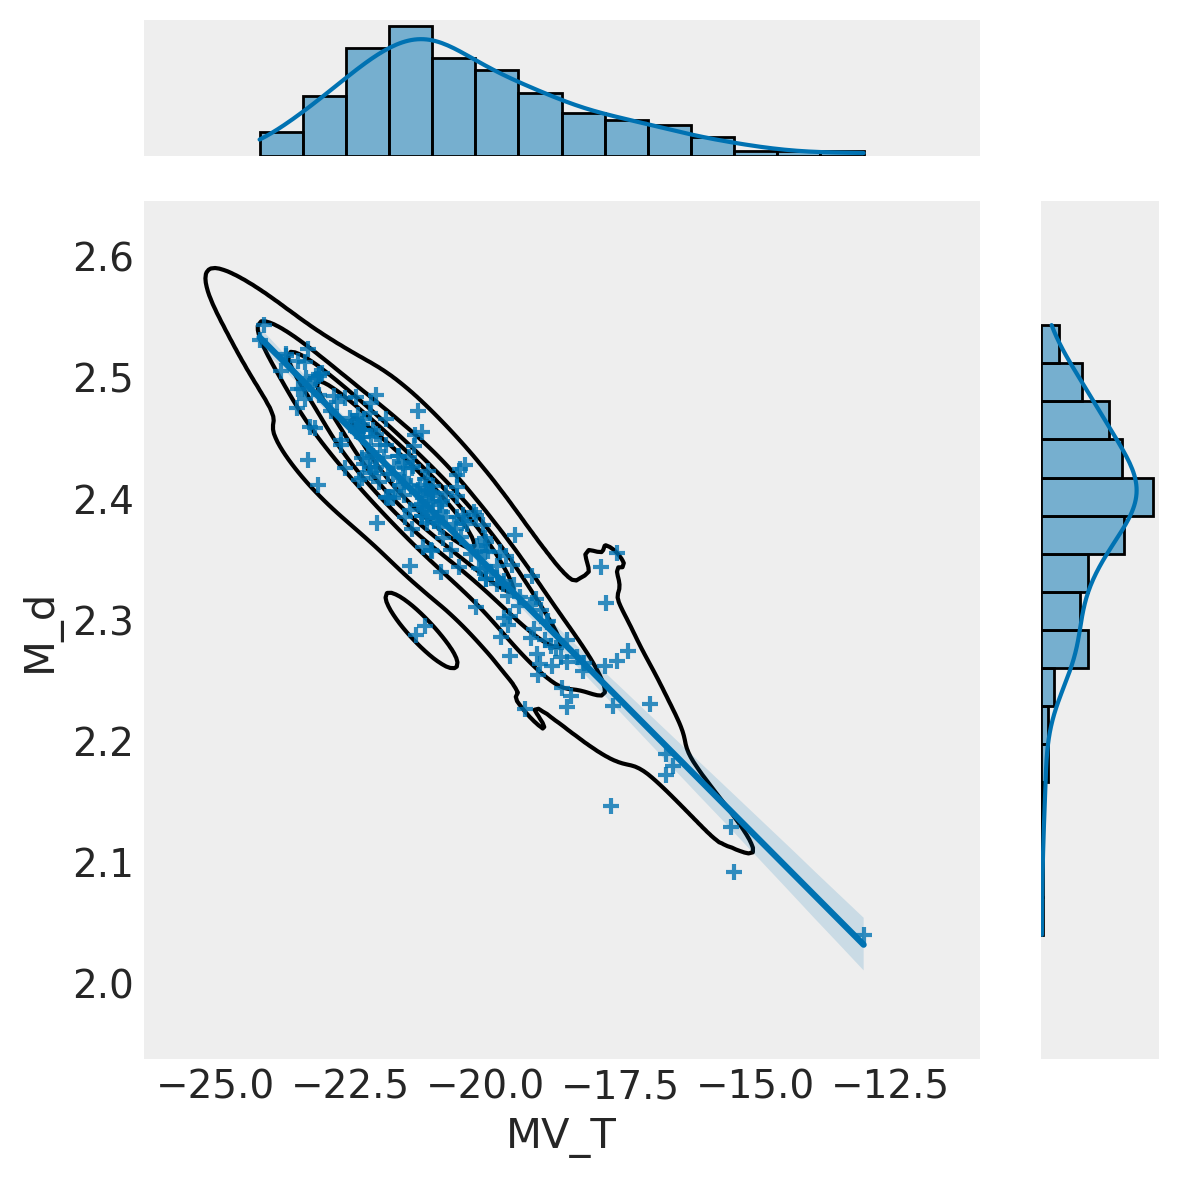

In [68]:
## plot box chart of luminosity
fig, ax = plt.subplots(figsize=(5, 2))
plot = sns.boxplot(data=dfgc, x='MV_T', ax=ax)
ax.set_xlabel('Absolute Luminosity')
plt.show()

## plot box chart of dynamical mass
fig, ax = plt.subplots(figsize=(5, 2))
plot = sns.boxplot(data=dfgc, x=dfgc[dfgc['M_d']>0]['M_d'], ax=ax)
ax.set_xlabel('Dynamical Mass')
plt.show()

## plot jointplot of luminosity and dynamical mass
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=dfgc, x='MV_T', y='M_d',
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.8)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6,color='k')
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()

## do the same but with log of dynamical mass
ax = plt.figure(figsize=(8, 8))
plot = sns.jointplot(data=dfgc, x='MV_T', y=np.log(dfgc['M_d']),
                     kind='reg', marker='+', ax=ax,
                     joint_kws = {'scatter_kws':dict(alpha=0.8)})
plot.plot_joint(sns.kdeplot, zorder=0, levels=6,color='k')
# ax.set_xlabel('X-ray Luminosity')
# ax.set_ylabel('Number of Galaxies')
plt.show()


We can see that, by taking the log of the mass, all of the null measurements are then exlcuded. As such, I thought using the zero inflated poisson method detailed in the guidance notebook would be appropriate, but I'll first try a standard poisson regression as a baseline.

### 3. Analysis
<a id='analysis'></a>

#### 3.1 Poission
<a id='analysis1'></a>

In [106]:
x = dfgc['MV_T']
y = np.log(dfgc['M_d'])
with pm.Model() as poisson_log:
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=-5)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)

    theta = b0 + b1 * x

    yvar = pm.Poisson('yvar', mu=np.exp(theta), observed=y)
    trace = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [b0, b1]
>Metropolis: [yvar_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b0,1.370,0.582,0.297,2.423,0.041,0.030,202.0,375.0,1.02
b1,0.030,0.028,-0.021,0.081,0.002,0.001,212.0,450.0,1.02
yvar_missing[0],2.738,1.922,0.000,6.000,0.090,0.066,494.0,565.0,1.01
yvar_missing[1],2.678,1.972,0.000,6.000,0.094,0.067,459.0,617.0,1.01
yvar_missing[2],2.715,1.956,0.000,6.000,0.108,0.092,446.0,379.0,1.02
...,...,...,...,...,...,...,...,...,...
yvar_missing[71],2.780,1.988,0.000,6.000,0.097,0.069,444.0,775.0,1.01
yvar_missing[72],2.527,1.918,0.000,6.000,0.093,0.068,456.0,576.0,1.01
yvar_missing[73],2.600,1.843,0.000,6.000,0.086,0.062,451.0,725.0,1.01
yvar_missing[74],2.502,1.879,0.000,6.000,0.098,0.073,404.0,523.0,1.02


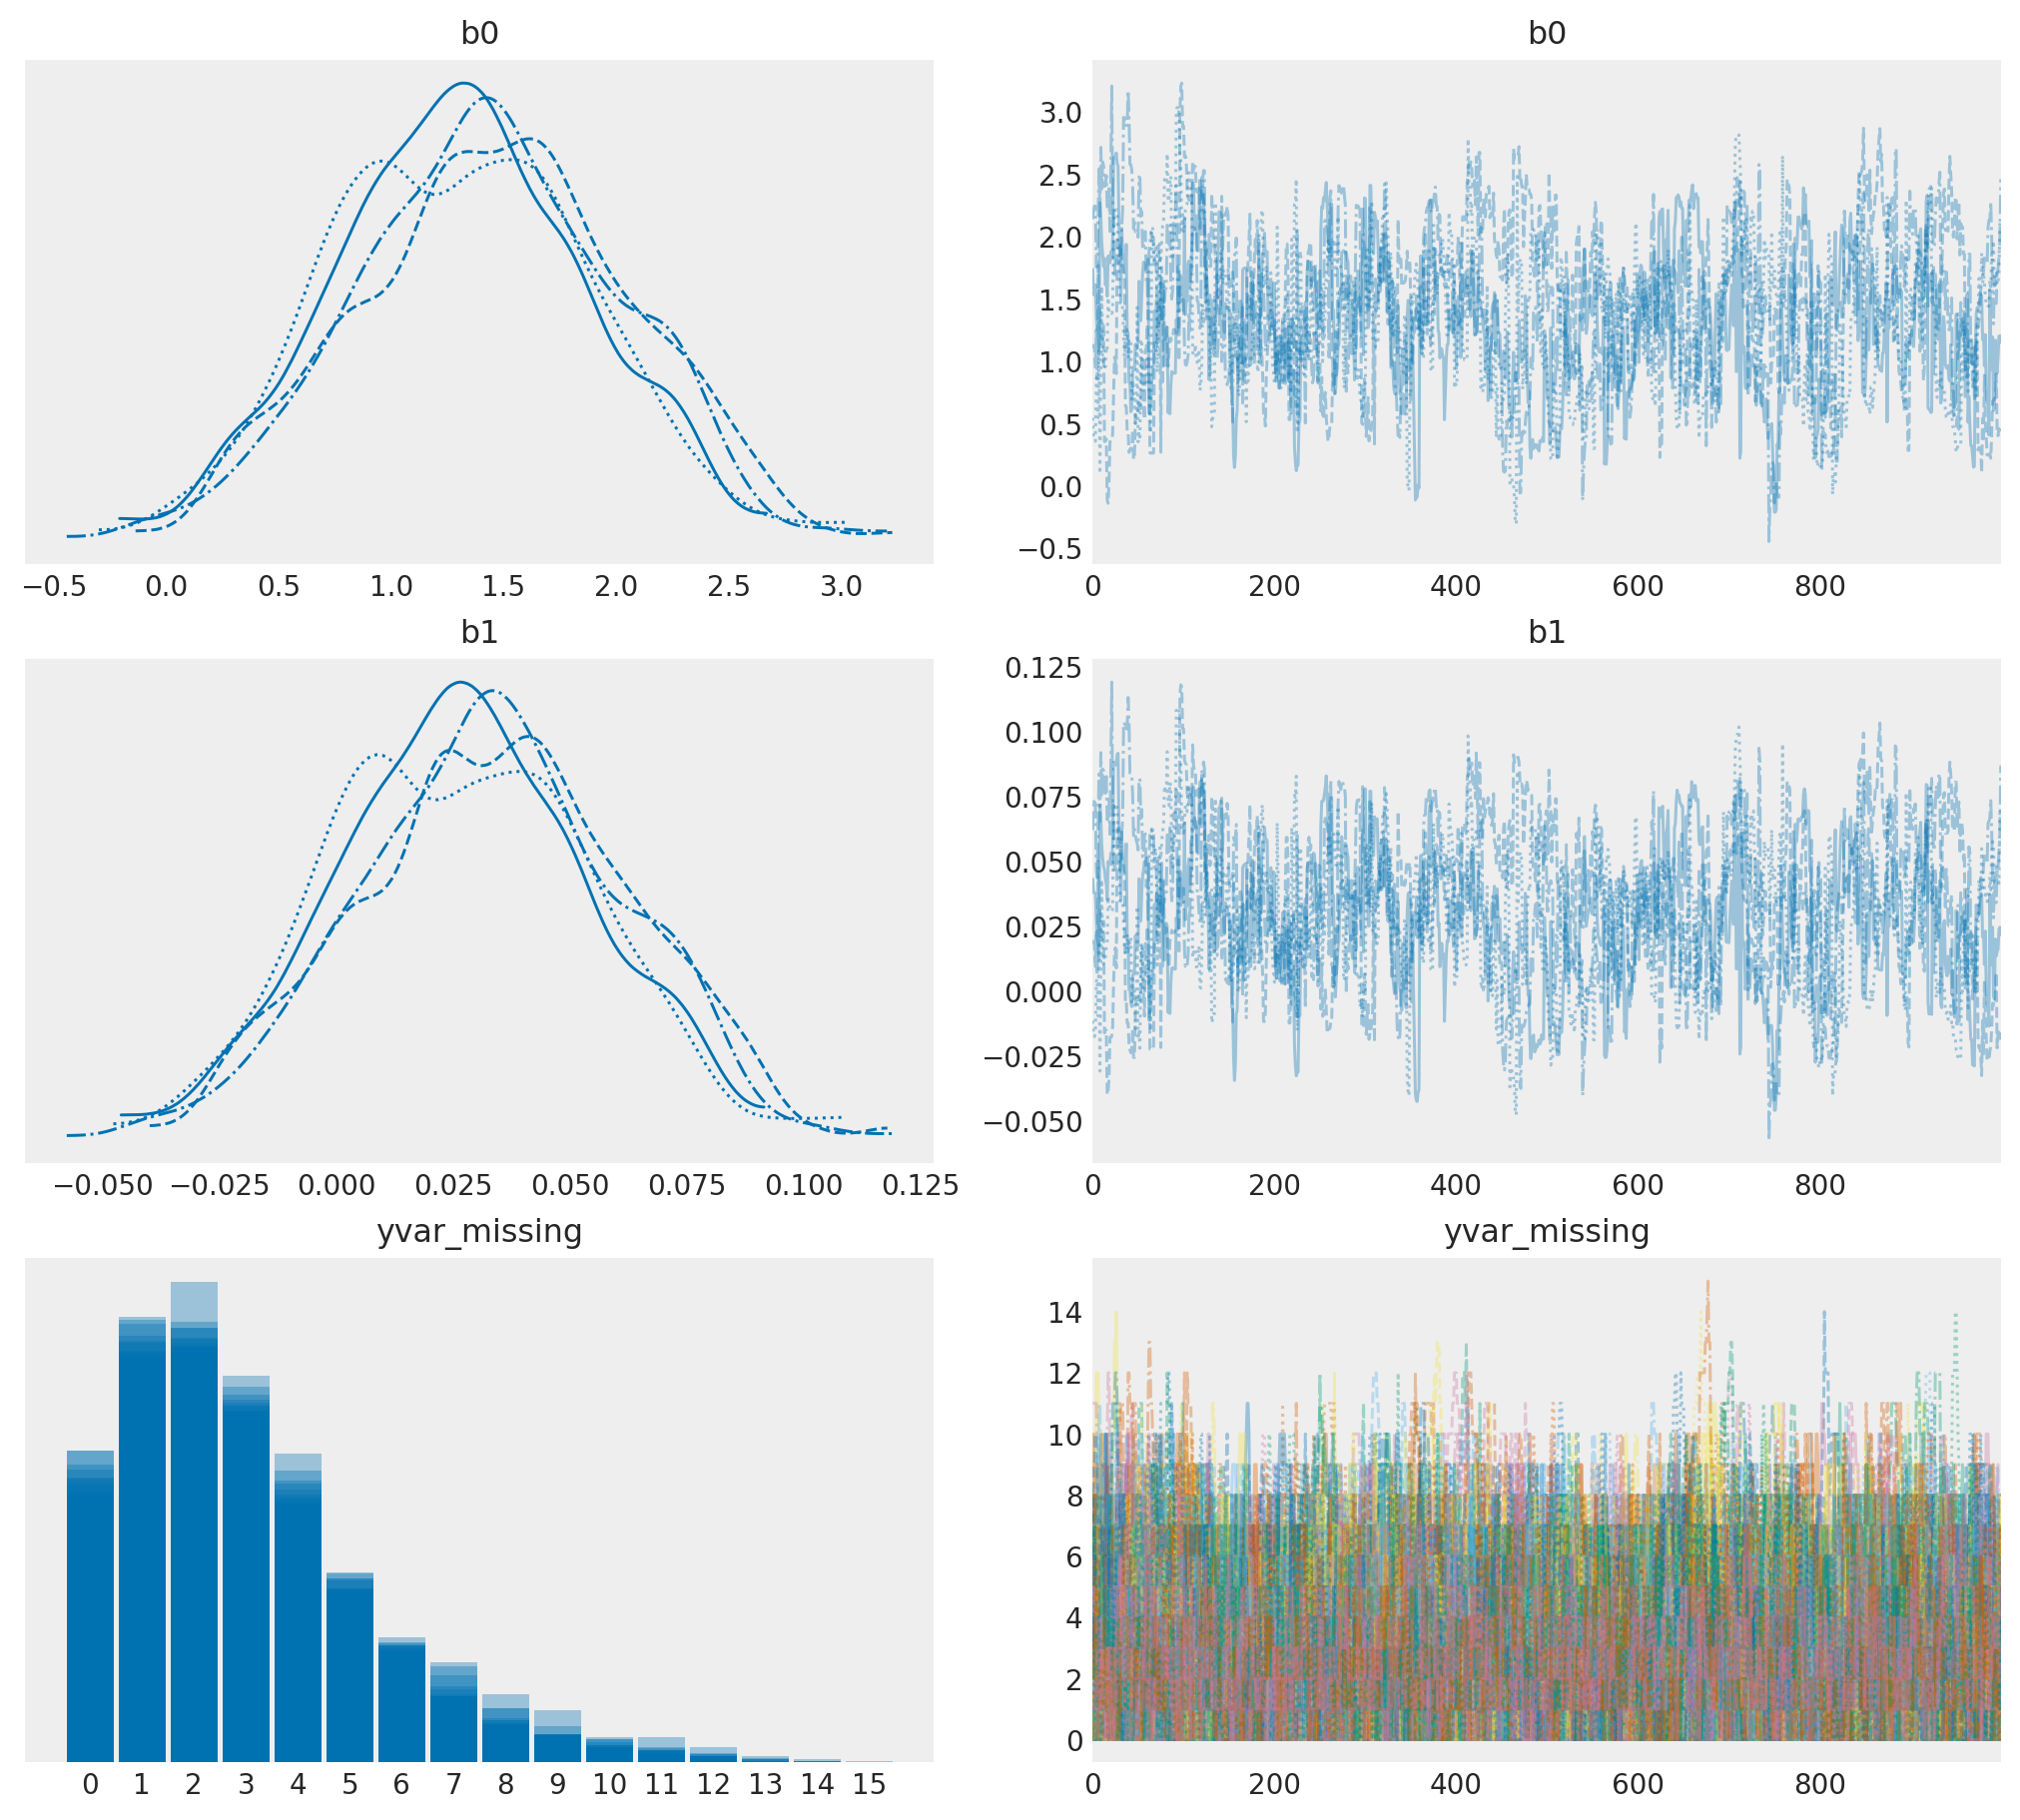

,mean,hdi_3%,hdi_97%
b0,1.37,0.30,2.42
b1,0.03,-0.02,0.08
yvar_missing[0],2.74,0.00,6.00
yvar_missing[1],2.68,0.00,6.00
yvar_missing[2],2.72,0.00,6.00
...,...,...,...
yvar_missing[71],2.78,0.00,6.00
yvar_missing[72],2.53,0.00,6.00
yvar_missing[73],2.60,0.00,6.00
yvar_missing[74],2.50,0.00,6.00


In [107]:
display(az.summary(trace))
az.plot_trace(trace,figsize=(10, 9));
plt.show()
display(az.summary(trace, round_to=2)[['mean','hdi_3%','hdi_97%']])

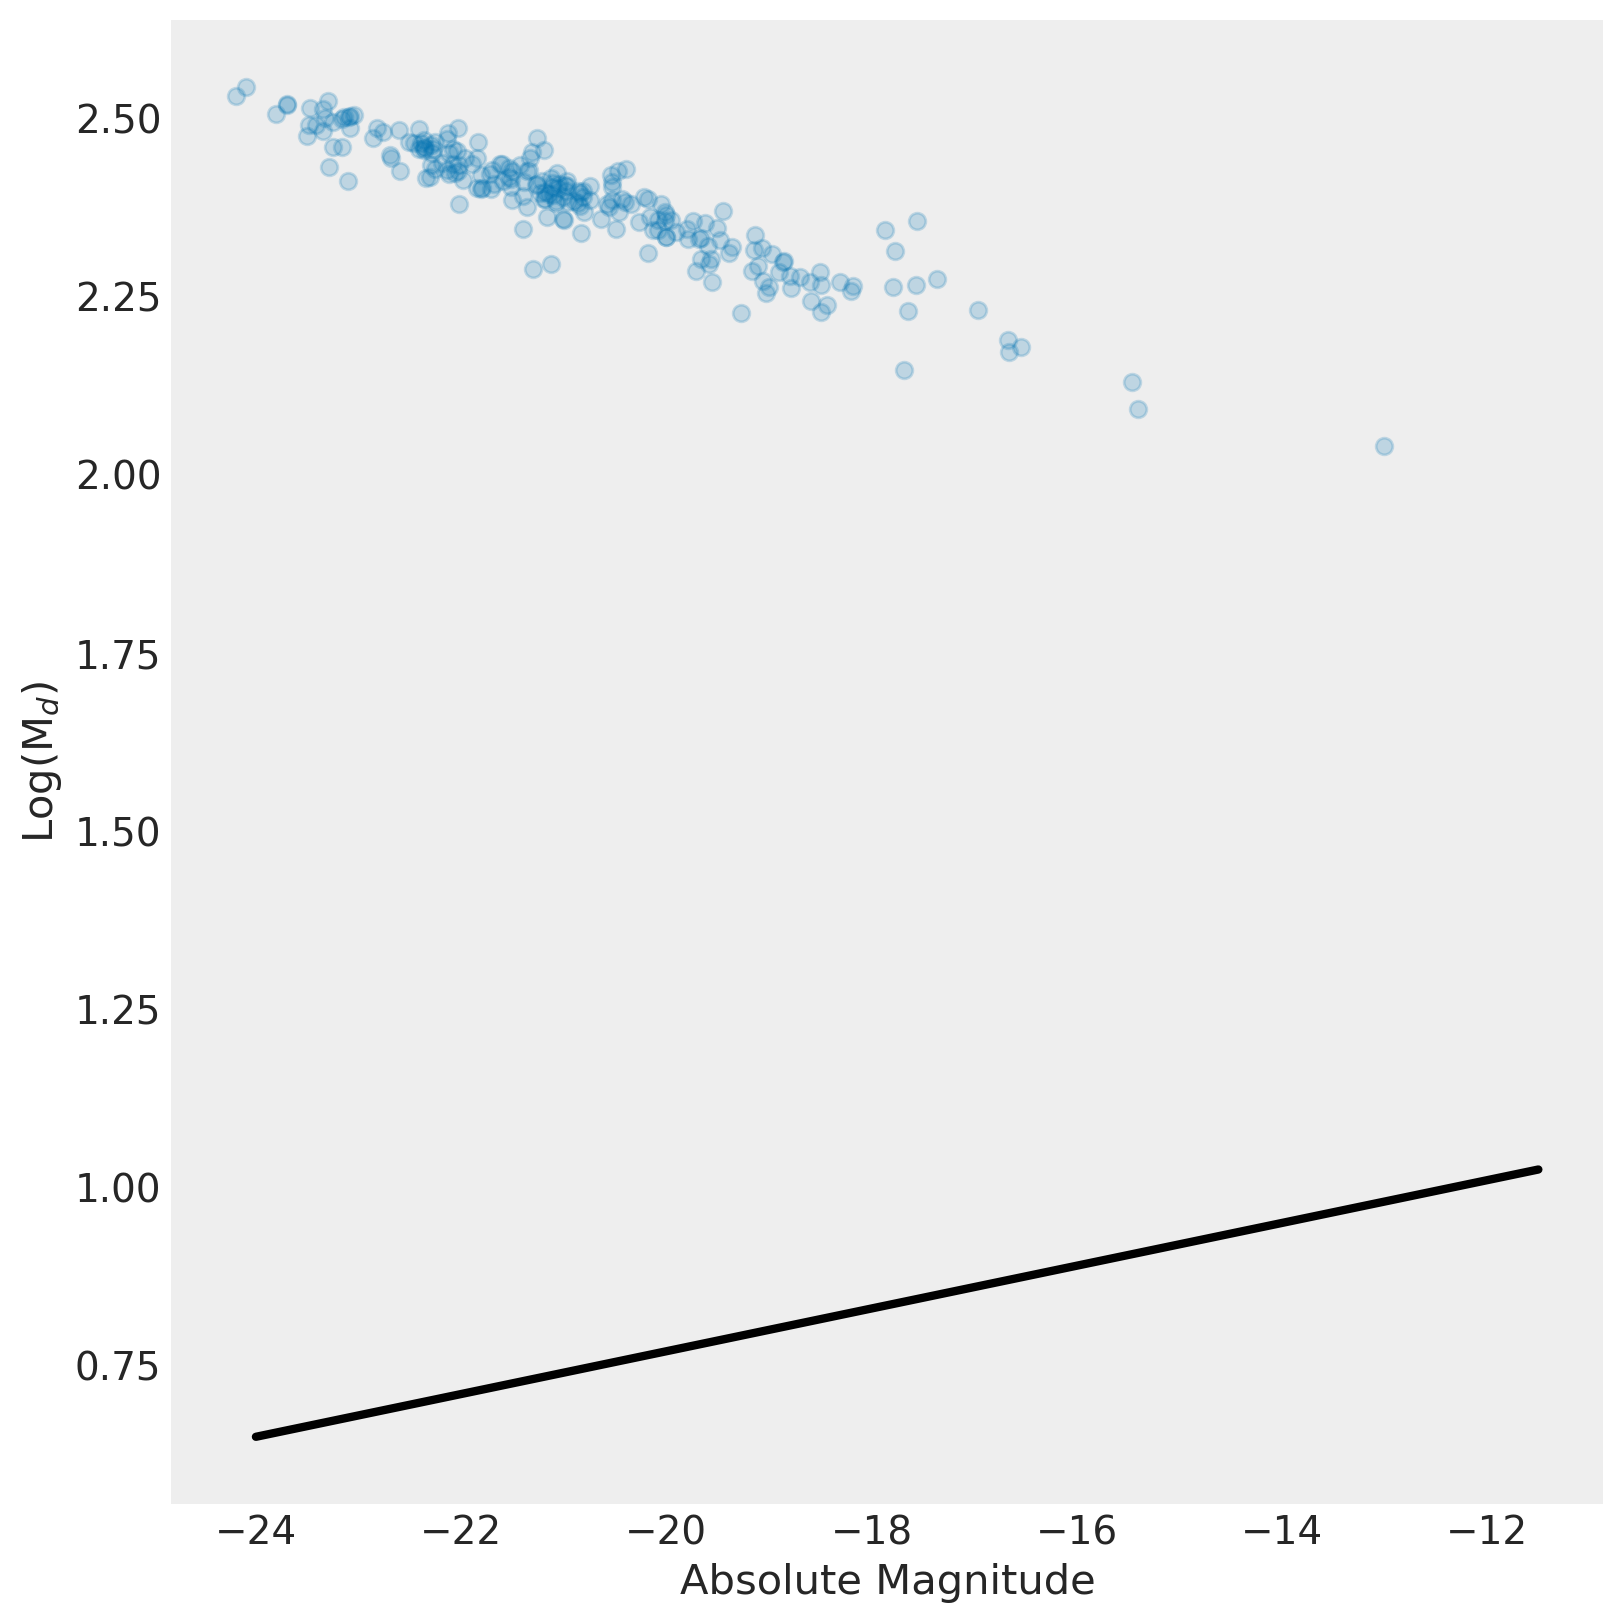

In [117]:
a = az.summary(trace)
beta_0 = a['mean']['b0']
beta_1 = a['mean']['b1']


xt=np.linspace(-24,-11.5,100)

BF = beta_0+xt*beta_1
#print(BF)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x , y, 
            alpha=0.2)
ax.plot(xt, BF, alpha=1, lw=3, color='k')

ax.set_xlabel(r'Absolute Magnitude')
ax.set_ylabel(r'Log(M$_{d}$)')
plt.show();

This doesn't seem to be the correct fitting, which I suspect is either due to the null values in the dynamical mass dataset or because I chose to take the log of the dynamical mass. The "yvar_missing" rows in the trace also suggest there's a mistake somewhere in this analysis. I'll try the zero inflated poisson method next.

#### 3.2 Zero Inflated Poission
<a id='analysis2'></a>

As detailed in the guidance notebook, the zero inflated poisson method is appropriate for data with a large number of null measurements. In this case, values of -9999 represent null measurements of the dynamical mass; one can see that there are a number of null values for the dynamical mass. As such, my thinking was that we could use the zero inflated poisson method to fit the data.

In [119]:
with pm.Model() as zip:
    b0 = pm.Normal('b0', mu=0, tau=1e-3, testval=-5)
    b1 = pm.Normal('b1', mu=0, tau=1e-3, testval=1)
    
    theta = b0 + b1*x
    pi = pm.Beta('pi', 1, 1)
    yvar = pm.ZeroInflatedBinomial('yvar', psi=pi, mu=np.exp(theta), 
                                   observed=y)
    trace_zip = pm.sample(1000, return_inferencedata=True)

TypeError: __new__() missing 2 required positional arguments: 'n' and 'p'

I'm not entirely sure why this issue is occuring since this code follows the guidance notebook, which doesn't seem to have this issue. I'll have to investigate this further.